# Multi-objective optimisation

# <span style="color:blue">Learning Objectives</span>

1. Implement multi objective evolution
2. Implement individuals with non-standard structures (in this case a set)

# <span style="color:blue">The knapsack problem</span>

The knapsack problem is a multi-objective problem: Given a set of possible items, each with a weight and a value, maximize the value of items in the bag, while minimizing the weight. There is also a weight restriction and restriction on the number of items in the bag.



A fixed number of items can be put in the bag. So the objectives for the bag is:
1. Min(weight)
2. Max(bag_value)

With the constraints:
- weight < limit
- numItems < maxItems

## <span style="color:blue">Defining the problem</span>

In [1]:
import random
import numpy
import operator

In [2]:
NBR_ITEMS = 100     # The number of items to choose from
MAX_ITEM = 50       # Max items that can be in the bag
MAX_WEIGHT = 50     # Max weight of the bag
IND_INIT_SIZE = 5   # The initial number of random items in a bag for a new individual

The below creates a dictionary of random items that can be added to the knapsack. Item name is an integer, and value is a (weight, value) tuple.

In [3]:
items = {}
for i in range(NBR_ITEMS):
    items[i] = (random.randint(1, 10), random.uniform(0, 100))

In [4]:
items

{0: (10, 45.86473183844939),
 1: (9, 65.50776804337953),
 2: (1, 32.256118608772034),
 3: (8, 92.80697910754643),
 4: (2, 22.197808084459993),
 5: (5, 0.49507935708993367),
 6: (7, 9.466392925151723),
 7: (9, 11.262357320168414),
 8: (10, 32.50190389213823),
 9: (5, 35.84002994666626),
 10: (3, 43.33315071507853),
 11: (3, 27.348079505418543),
 12: (8, 50.20514934951182),
 13: (6, 86.64231889932347),
 14: (6, 90.34891647685137),
 15: (4, 26.717369526899315),
 16: (4, 27.80613356198913),
 17: (1, 18.296104150372162),
 18: (7, 78.23796505610301),
 19: (10, 25.8284576138079),
 20: (3, 22.314108259342014),
 21: (1, 48.304028363087845),
 22: (8, 99.89544164016449),
 23: (7, 24.06419636490902),
 24: (7, 30.362911251027747),
 25: (4, 3.9905549817938035),
 26: (8, 53.638587211787616),
 27: (10, 64.1596624394683),
 28: (2, 81.65975576699928),
 29: (3, 79.3179898982727),
 30: (2, 99.30997353048976),
 31: (3, 71.82774807007003),
 32: (10, 61.94604018922729),
 33: (2, 81.21577351663977),
 34: (5, 

## <span style="color:blue">The GA</span>

In [5]:
!pip install deap

zsh:1: command not found: pip


In [6]:
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

Many evolutionary algorithm textbooks mention that the best way to have an efficient algorithm is to have a representation close the problem. **Thus, we let our individuals inherit from the set class.** You can of course try different representations.

In [7]:
creator.create("Fitness", base.Fitness, weights=(-1.0, 1.0))
creator.create("Individual", set, fitness=creator.Fitness)

Set up your toolbox below by adding attr_item and individual.

In [8]:
toolbox = base.Toolbox()
toolbox.register("attr_item", random.randrange, NBR_ITEMS)
toolbox.register("individual", tools.initRepeat, creator.Individual,
    toolbox.attr_item, IND_INIT_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

Next define your evaluation function.  

Remember that now we need to return two fitness items (weight and value). To ensure overweighted bags are always dominated, set the weight high (10000) and the value to zero for those that violate the constrains.

In [9]:
def evalKnapsack(individual):
    weight = 0.0
    value = 0.0
    for item in individual:
        weight += items[item][0]
        value += items[item][1]
    if len(individual) > MAX_ITEM or weight > MAX_WEIGHT:
        return 10000, 0
    return weight, value

The crossover and mutation operators in DEAP cannot be applied directly on sets. So you need to define your own.

We produce two children where the first child is the intersection of the two parent sets and the second child their absolute difference.

In [10]:
def cxSet(ind1, ind2):
    temp = set(ind1)                # Used in order to keep type
    ind1 &= ind2                    # Intersection (inplace)
    ind2 ^= temp                    # Absolute difference (inplace)
    return ind1, ind2

Items in sets cannot be changed, but you can remove or add elements. Thus, mutation pops or adds elements to the set (i.e. adds or removes an item from the bag).

In [11]:
def mutSet(individual):
    if random.random() < 0.5:
        if len(individual) > 0:
            individual.remove(random.choice(sorted(tuple(individual))))
    else:
        individual.add(random.randrange(NBR_ITEMS))
    return individual,

In [12]:
toolbox.register("evaluate", evalKnapsack)
toolbox.register("mate", cxSet)
toolbox.register("mutate", mutSet)

We have registered our functions in the toolbox. For select we use tools.selNSGA2, to use the NSGA2 algorithm.

In [13]:
toolbox.register("select", tools.selNSGA2)

In [14]:
inv1 = toolbox.individual()

In [15]:
print(inv1)

Individual({24, 89, 98, 77})


I next define a function for comparing whether two solutions are equal. The numpy.close function can also be given a tolerence, which you could increase.

It is important to note that this function should typically work on the solution, rather than fitness. This is because we want variation in the solutions along the front, and different solutions might have similar fitnesses for more complex problems. However, here we variable solution lengths and this can be done on the fitness, which is likely to lead to similar results here.

It would be possible to write your own function here that only returns true if the solution is the same length, and if they are then sorting and comparing the solutions. You can have a go at writing this in the workshop if you finish the workshop mateiral.

In [16]:
def pareto_eq(ind1, ind2):
    return numpy.allclose(ind1.fitness.values, ind2.fitness.values)

In [17]:
NGEN = 250
CXPB = 0.5
MUTPB = 0.2
popSize = MU = 200
LAMBDA = 400

In [18]:
pop = toolbox.population(n=popSize)
hof = tools.ParetoFront(similar=pareto_eq)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean, axis=0)
stats.register("std", numpy.std, axis=0)
stats.register("min", numpy.min, axis=0)
stats.register("max", numpy.max, axis=0)

Below, we use a built-in algorithm for brevity. Here, we use the Mu + Lambda algorithm. This just allows us to specify two more parameters. Lambda is the number of individuals to reproduce into the next generation (we just set it to a constant population size) and Mu is the number of children to produce in each generation. We set this to double the population size so that we have choice when it comes to selection.

In [19]:
pop, log = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats, halloffame=hof)

gen	nevals	avg                      	std                      	min                      	max                        
0  	200   	[ 27.09      233.6608334]	[ 6.30094437 59.61991511]	[ 8.         35.54495221]	[ 41.         364.41959798]
1  	287   	[ 3.725      55.07991153]	[  8.28850861 115.80938289]	[0. 0.]                  	[ 36.         402.67767331]
2  	277   	[ 2.285      39.57007355]	[  6.23488372 100.20028468]	[0. 0.]                  	[ 32.         443.73758788]
3  	287   	[ 3.81       65.57321681]	[  7.8558195  125.72059183]	[0. 0.]                  	[ 34.         446.60147798]
4  	281   	[ 1.665      30.54520715]	[ 6.15977069 96.83334052]  	[0. 0.]                  	[ 36.         533.74431437]
5  	273   	[ 2.995      51.79036211]	[  8.5606644  128.61740918]	[0. 0.]                  	[ 36.         533.74431437]
6  	274   	[ 5.39       91.94167546]	[ 11.09945494 161.39033678]	[0. 0.]                  	[ 39.         556.05842263]
7  	287   	[  6.27       113.11052791]	[ 11.44364889

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

gen = log.select("gen")
avgs = log.select("avg")
stds = log.select("std")

In [21]:
avgs_weight = [item[0] for item in avgs]
avgs_value = [item[1] for item in avgs]

In [22]:
avgs

[array([ 27.09     , 233.6608334]),
 array([ 3.725     , 55.07991153]),
 array([ 2.285     , 39.57007355]),
 array([ 3.81      , 65.57321681]),
 array([ 1.665     , 30.54520715]),
 array([ 2.995     , 51.79036211]),
 array([ 5.39      , 91.94167546]),
 array([  6.27      , 113.11052791]),
 array([ 3.79      , 74.34666899]),
 array([  5.625     , 110.67945664]),
 array([  8.        , 154.28507856]),
 array([  7.09      , 136.92515401]),
 array([ 11.46      , 205.78125887]),
 array([ 12.295     , 229.24444204]),
 array([ 11.03      , 202.65818248]),
 array([  6.61      , 144.87841279]),
 array([  6.4       , 145.18727933]),
 array([  5.785    , 141.5932024]),
 array([  8.15      , 201.24888883]),
 array([  7.81      , 188.84664576]),
 array([ 13.34      , 308.40596799]),
 array([ 17.585     , 378.47279961]),
 array([ 23.145     , 417.70678348]),
 array([ 28.535    , 503.4549856]),
 array([  7.195     , 217.17852753]),
 array([  8.885     , 222.54553462]),
 array([  7.255     , 169.711505

Text(0, 0.5, 'Fitness (weight)')

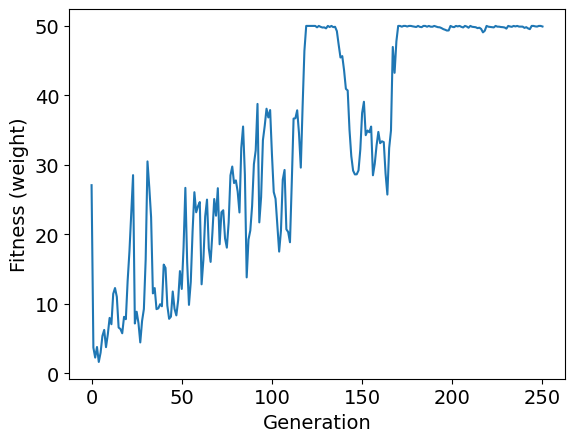

In [23]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs_weight)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness (weight)")

Text(0, 0.5, 'Fitness (value)')

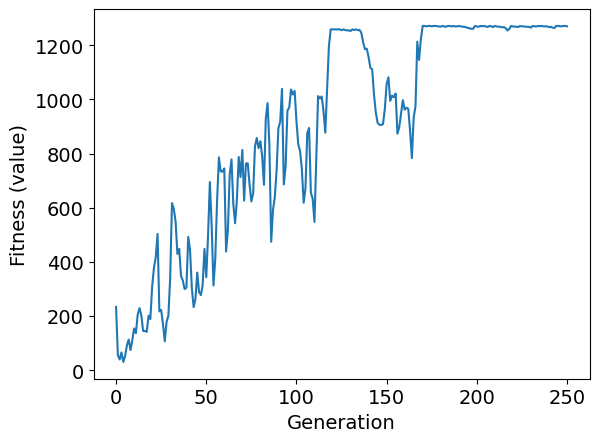

In [24]:
fig2, ax2 = plt.subplots()
line2 = ax2.plot(gen, avgs_value)
ax2.set_xlabel("Generation")
ax2.set_ylabel("Fitness (value)")

Normally we would now plot the Pareto front. But here we have solutions that have anything from 0 upwards of solution dimensions (i.e. what is in the bag). So we can't plot the solution space very easily. You will, however, be doing this in the workshop.